# Stock Price Forecasting Using SVR

This notebook performs time-series forecasting on GOOGL stock using SVR. The process includes data collection, preprocessing, EDA, model training, and evaluation.

## Step 1: Data Collection and Preprocessing

### 1.1 Import Libraries

In [59]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### 1.2 Download GOOGL Stock Data

In [60]:
df = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
df.reset_index(inplace=True)

/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_46248/2529565348.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
[*********************100%***********************]  1 of 1 completed


### 1.3 Preprocess the Dataset

In this step, I cleaned up the dataset by removing unnecessary columns like 'Open' and applied a log transformation to the 'Volume' column to handle skewness. I also created two time-based features, day_of_week and day_of_year to capture potential seasonality or weekday patterns in the stock market. The target variable was defined as the next day’s closing price using a one-step shift. Finally, I scaled the numerical features ('Close', 'High', 'Low', 'log_volume', day_of_week, day_of_year) using MinMaxScaler so the model can process everything on the same scale.


In [61]:
# Drop unused columns
df.drop(['Open'], axis=1, inplace=True)

# Log transform the volume column
df['log_volume'] = np.log(df['Volume'] + 1e-8)
df.drop('Volume', axis=1, inplace=True)

# Add time-based features
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear

# Creating target variable (next day's close)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

# Normalize numeric features
features = ['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

# Show processed data
print("Processed data shape:", df.shape)
df.head()

Processed data shape: (2870, 8)


/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_46248/2082377432.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['Open'], axis=1, inplace=True)
/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_46248/2082377432.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop('Volume', axis=1, inplace=True)


Price,Date,Close,High,Low,log_volume,day_of_week,day_of_year,Target
Ticker,,GOOGL,GOOGL,GOOGL,,,,
0,2010-01-04,0.043888,0.042402,0.044232,0.512315,0.00,0.005495,15.522273
1,2010-01-05,0.043253,0.042024,0.043605,0.615658,0.25,0.008242,15.130977
2,2010-01-06,0.039633,0.041575,0.040083,0.683269,0.50,0.010989,14.778734
3,2010-01-07,0.036373,0.037983,0.036901,0.798267,0.75,0.013736,14.975752
4,2010-01-08,0.038196,0.036455,0.036080,0.724629,1.00,0.016484,14.953115


## Step 2: Exploratory Data Analysis (EDA)

### 2.1 Price Trend Over Time

This line plot shows how Google's closing stock price has moved over time after normalization. The overall upward trend reflects the company's growth from 2010 to 2021, with a few sharp dips likely due to external market events. This helps give a clear picture of the long-term behavior of the stock and shows that the data follows a consistent trend, which is useful when building time series forecasting models.


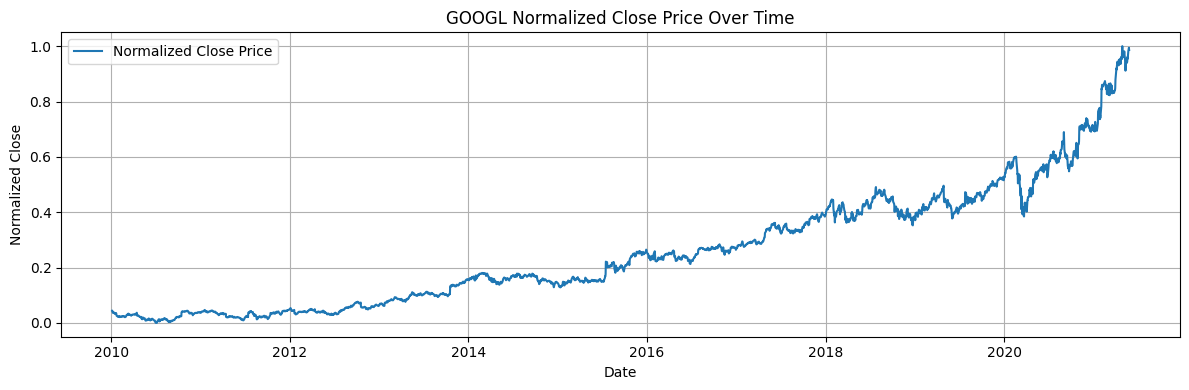

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Close'], label='Normalized Close Price')
plt.title("GOOGL Normalized Close Price Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Close")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 2.2 Target Distribution (Next Day Close Price)

The histogram shows how the target variable (next day's closing price) is spread across the dataset. Most of the values are clustered in the lower range, with fewer occurrences at higher prices, which makes sense given the stock's long-term growth. Since the target values are continuous and don’t have sharp breaks or gaps, this confirms that regression is a suitable approach for predicting the next day's price.



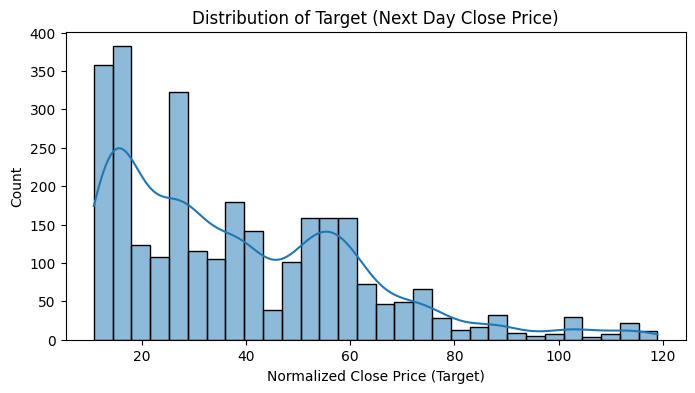

In [63]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df['Target'], bins=30, kde=True)
plt.title('Distribution of Target (Next Day Close Price)')
plt.xlabel('Normalized Close Price (Target)')
plt.show()


### 2.3 Autocorrelation and Partial Autocorrelation Analysis



The ACF and PACF plots help us understand how past values of the closing price are related to future ones. In the ACF plot, we see that autocorrelation remains very high even after 30 days, which shows that the stock price has a strong trend and memory — it's heavily influenced by its past.

In contrast, the PACF plot shows that the correlation drops sharply after the first 2–3 lags. This means most of the useful predictive information comes from the most recent values. Based on this, using a sliding window of 5 previous days (as done in our SVR model) is a reasonable choice, as additional lags add little new information.


<Figure size 1000x400 with 0 Axes>

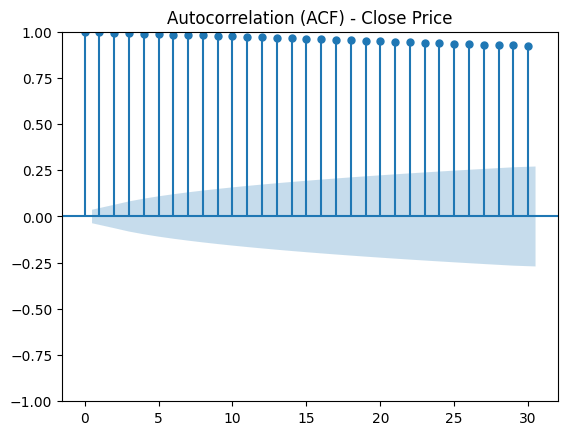

<Figure size 1000x400 with 0 Axes>

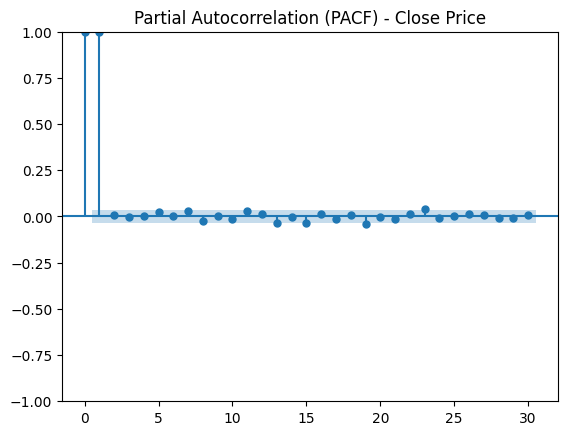

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Autocorrelation plot
plt.figure(figsize=(10, 4))
plot_acf(df['Close'], lags=30)
plt.title('Autocorrelation (ACF) - Close Price')
plt.show()

# Partial autocorrelation plot
plt.figure(figsize=(10, 4))
plot_pacf(df['Close'], lags=30)
plt.title('Partial Autocorrelation (PACF) - Close Price')
plt.show()


### 2.4 Moving Average and Volatility

This chart shows the closing price of the stock along with its 20-day moving average and the volatility range around it. The moving average helps smooth out the daily ups and downs so we can see the overall trend more clearly. The shaded area shows how much the price was moving around that average — wider bands mean the stock was more unpredictable at that time. Even though our model only uses the last 5 days for prediction, the 20-day window here is just for visual analysis. It helps us understand when the stock was more stable and when it was going through sharp changes.


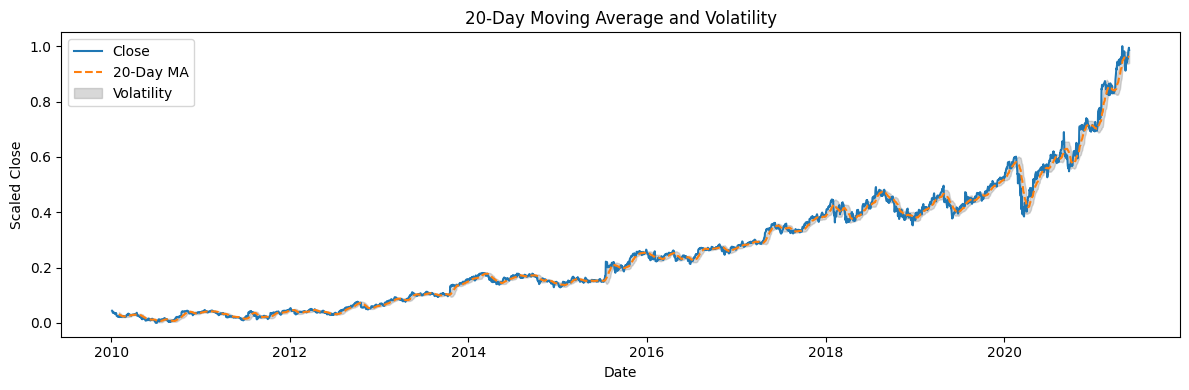

In [65]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Volatility_20'] = df['Close'].rolling(window=20).std()

plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_20'], label='20-Day MA', linestyle='--')
plt.fill_between(df['Date'], df['MA_20'] - df['Volatility_20'], df['MA_20'] + df['Volatility_20'], color='gray', alpha=0.3, label='Volatility')
plt.title("20-Day Moving Average and Volatility")
plt.xlabel("Date")
plt.ylabel("Scaled Close")
plt.legend()
plt.tight_layout()
plt.show()

### 2.5 Correlation Heatmap

The heatmap shows how each feature is correlated with the target variable (next day’s close price). As expected, the current day's Close, High, and Low prices all have a perfect correlation with the target, since they are highly overlapping in nature. Interestingly, log-transformed volume has a strong negative correlation with the target, suggesting an inverse relationship. Time-based features like day_of_week and day_of_year show very weak correlations, which is common in financial data. This visualization helped validate which features carry useful signals and which ones may have limited predictive power.


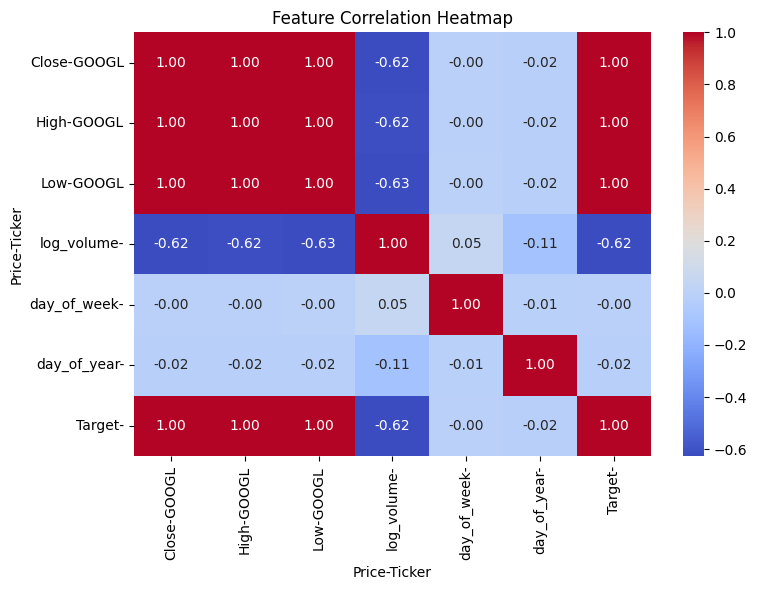

In [66]:
import seaborn as sns
plt.figure(figsize=(8, 6))
corr = df[['Close', 'High', 'Low', 'log_volume', 'day_of_week', 'day_of_year', 'Target']].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

### 2.6 Boxplots for Outlier Detection

This plot shows how the main numerical features i.e Close, High, Low, and log_volume, are distributed and whether they have any unusual values. 

The boxes represent where most of the values lie (the middle 50%), and the small circles on top of each box are potential outliers. All four features show some outliers, which is expected in stock market data due to sudden spikes or drops.

I didn’t remove these outliers because they can reflect real market events and might be important for the model to learn from. This visual just helped us get a quick sense of how clean or noisy the data is.

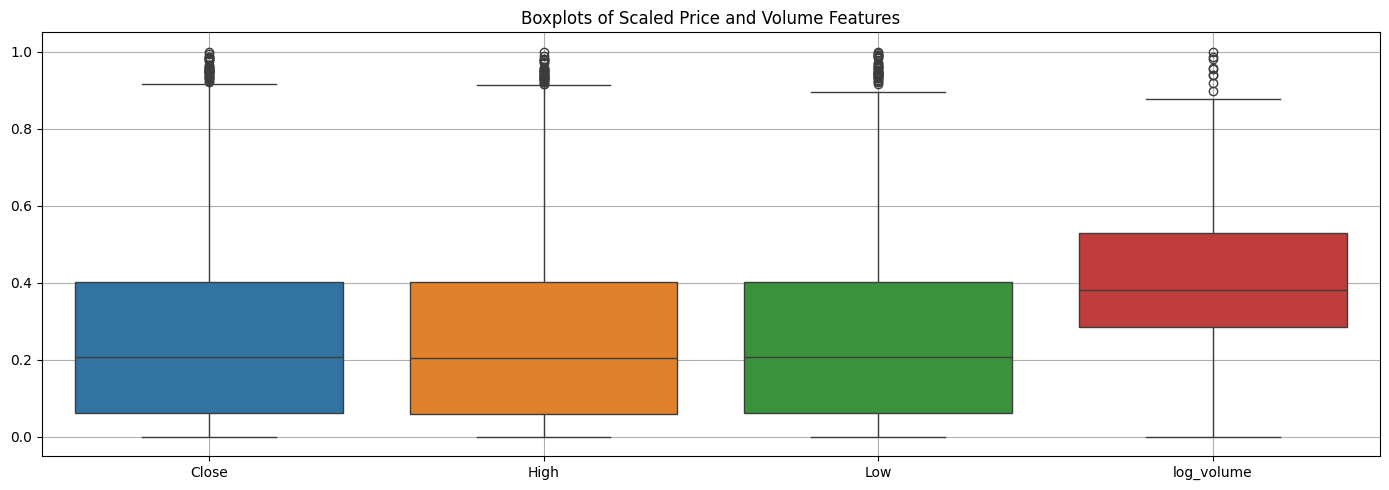

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
sns.boxplot(data=df[['Close', 'High', 'Low', 'log_volume']])
plt.title("Boxplots of Scaled Price and Volume Features")
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.5 Distribution Plots for Feature Analysis

In this section, I looked at how some of the main features in the dataset are distributed. The first plot shows the distribution of the normalized close prices, which is right-skewed and this is expected, as stock prices generally rise over time.

The second plot shows the log-transformed trading volume. Applying the log helped reduce skewness and made the values more balanced. 
 
The third plot is for the Target variable (next day’s closing price), and its shape is very similar to the Close price, which makes sense since it’s derived from it. These plots helped check for any major imbalances or issues in the data. Since normalization was already applied earlier, no further changes were needed.



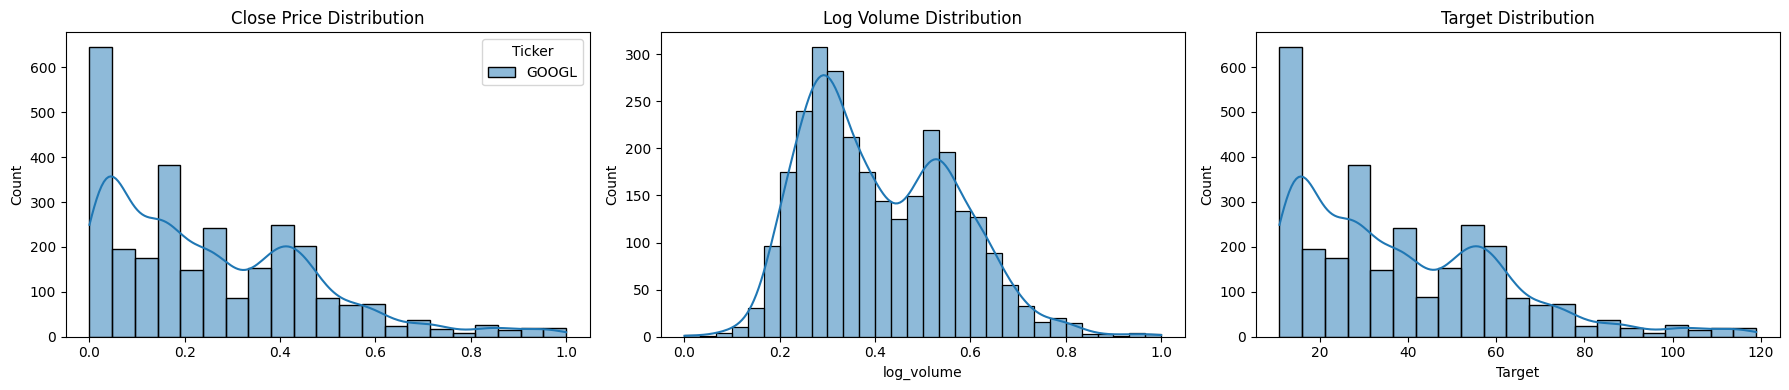

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['Close'], kde=True, ax=axes[0]).set(title='Close Price Distribution')
sns.histplot(df['log_volume'], kde=True, ax=axes[1]).set(title='Log Volume Distribution')
sns.histplot(df['Target'], kde=True, ax=axes[2]).set(title='Target Distribution')
plt.tight_layout()
plt.show()

### 2.6 Skewness and kurtosis of key features

To get a better sense of the distribution shape of some key features, I looked at their skewness and kurtosis. The skewness values show that both the Close and Target features are moderately right-skewed, meaning the data has a longer tail on the higher side — which is pretty typical for stock prices since they generally trend upwards over time. The log_volume feature is also slightly right-skewed, though much less so. 

When it comes to kurtosis, both Close and Target show positive values, indicating slightly heavier tails compared to a normal distribution, suggesting the presence of more extreme values or outliers. log_volume, on the other hand, has a negative kurtosis, which means it's a bit flatter with fewer extreme values. This analysis helps confirm what was seen visually in the distribution plots and further justifies the scaling and transformation steps taken earlier.

In [69]:

print("Skewness:")
print(df[['Close', 'log_volume', 'Target']].skew())

print("\nKurtosis:")
print(df[['Close', 'log_volume', 'Target']].kurt())


Skewness:
Price       Ticker
Close       GOOGL     0.977986
log_volume            0.481594
Target                0.981930
dtype: float64

Kurtosis:
Price       Ticker
Close       GOOGL     0.629548
log_volume           -0.367721
Target                0.642607
dtype: float64


### 2.7 Time Series Decomposition

This chart breaks down the closing price into three separate components: trend, seasonality, and residual (noise). The trend shows the overall long-term direction of the stock, which in this case steadily increases over time. The seasonal component highlights repeating patterns that occur yearly—such as dips or spikes during certain months. The residual captures the random fluctuations that can’t be explained by trend or seasonality. We used a multiplicative model here because the size of both seasonal swings and random noise increases as the stock price grows, which is common in financial time series.


/var/folders/_p/s_spyhn14rx00tssgxdn92q00000gn/T/ipykernel_46248/1079491262.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  googl_raw = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
[*********************100%***********************]  1 of 1 completed


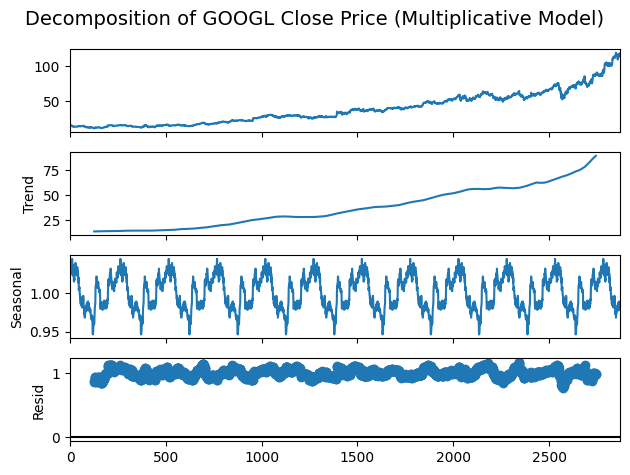

In [70]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose unscaled close values for better interpretation
googl_raw = yf.download("GOOGL", start="2010-01-01", end="2021-05-31")
googl_raw = googl_raw.reset_index()
result = seasonal_decompose(googl_raw['Close'], model='multiplicative', period=252)
result.plot()
plt.suptitle("Decomposition of GOOGL Close Price (Multiplicative Model)", fontsize=14)
plt.tight_layout()
plt.show()

### 2.7 Lag Feature Correlation

This heatmap shows how the closing prices from the previous five days (lag_1 to lag_5) are correlated with each other and with the Target (which is the next day’s closing price). All the lag features show very strong positive correlation with the target, which is exactly what we were hoping to see-it tells us that the past few days' prices are good predictors of tomorrow’s price. That’s why we used a 5-day sliding window in our model. The consistent high correlation across all lags also suggests there’s a strong trend and dependency in the time series, which makes these lagged values meaningful as features in the SVR model.

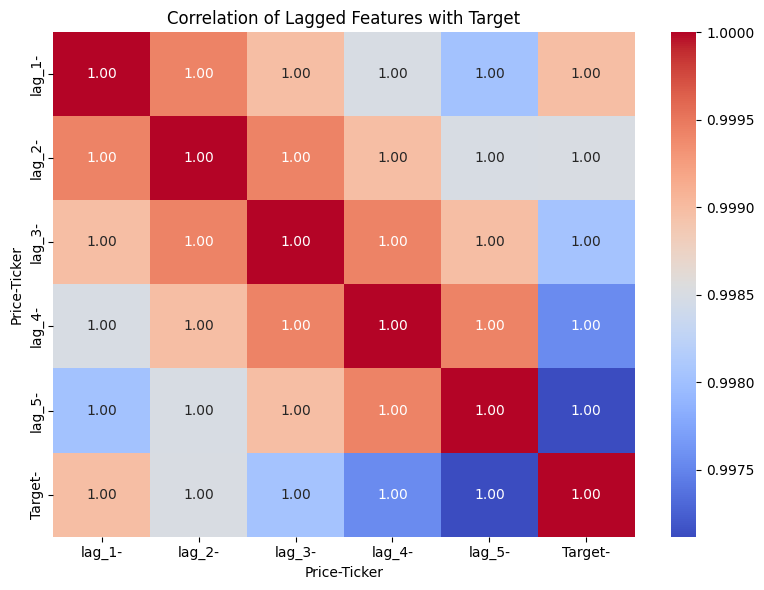

In [71]:
# Create lag features
for lag in range(1, 6):
    df[f'lag_{lag}'] = df['Close'].shift(lag)

# Drop NA values due to lagging
lagged_df = df.dropna()

# Correlation heatmap with lag features
plt.figure(figsize=(8, 6))
sns.heatmap(lagged_df[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'Target']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Lagged Features with Target")
plt.tight_layout()
plt.show()

## Step 3: Support Vector Regression (SVR)

### 3.1 Prepare Features and Labels

In this step, I used the last 5 days of closing prices to predict the next day’s price. A for-loop slides through the data, taking a 5-day window (i-5 to i) as input (X) and the 6th day (i) as the target (y). This creates a feature-label pair for each day after the first 5, helping the model learn short-term patterns in stock movement.

 Note: Although I explored several features like High, Low, Volume, day_of_week, etc. during EDA, the SVR model here only uses the past 5 days of normalized closing prices as input features. This was done to maintain a clean and consistent univariate input for evaluating SVR performance.


In [54]:
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

X = []
y = []
close_vals = df['Close'].values
target_vals = df['Target'].values

for i in range(5, len(close_vals)):  #5 day sliding window
    X.append(close_vals[i-5:i])
    y.append(target_vals[i])

X = np.array(X)
y = np.array(y)
X = X.reshape(X.shape[0], X.shape[1])

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (2865, 5)
y shape: (2865,)


### 3.2 Train-Test Split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

### 3.3 Train SVR Models with Different Kernels

I trained three SVR models using different kernels: Linear, Polynomial (degree 3), and RBF. Each model was trained on the same dataset and evaluated using MAE, RMSE, and SMAPE for a fair comparison.

Even after running hyperparameter tuning (like tweaking C, gamma, and epsilon) for the RBF model, it didn’t outperform the linear SVR. In fact, the linear kernel gave the most reliable results overall both in terms of accuracy and consistency. The polynomial one, on the other hand, clearly overfitted the data and gave unstable predictions.

In [56]:
svr_linear = SVR(kernel='linear')
svr_poly = SVR(kernel='poly', degree=3)
svr_rbf = SVR(kernel='rbf')

svr_linear.fit(X_train, y_train)
svr_poly.fit(X_train, y_train)
svr_rbf.fit(X_train, y_train)

pred_linear = svr_linear.predict(X_test)
pred_poly = svr_poly.predict(X_test)
pred_rbf = svr_rbf.predict(X_test)

### 3.4 Evaluating the Models

In [57]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

print("SVR with Linear kernel")
print("MAE:", mean_absolute_error(y_test, pred_linear))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_linear)))
print("SMAPE:", smape(y_test, pred_linear))

print("\nSVR with Polynomial kernel")
print("MAE:", mean_absolute_error(y_test, pred_poly))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_poly)))
print("SMAPE:", smape(y_test, pred_poly))

print("\nSVR with RBF kernel")
print("MAE:", mean_absolute_error(y_test, pred_rbf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_rbf)))
print("SMAPE:", smape(y_test, pred_rbf))

SVR with Linear Kernel
MAE: 1.3716138055215772
RMSE: 1.9118163555733472
SMAPE: 1.868682315601612

SVR with Polynomial Kernel
MAE: 100.196877792367
RMSE: 201.2823208510778
SMAPE: 46.18492200788709

SVR with RBF Kernel
MAE: 24.198056545398448
RMSE: 35.16398852414276
SMAPE: 36.82810722376953


### 3.5 Plot Predictions vs Actual

The plot shows how well each SVR model matched the actual stock prices. The linear SVR closely follows the real values, while the polynomial model drifts off with unrealistic patterns. The RBF model captures some trends but still misses key movements. Overall, the linear SVR gave the most reliable results.

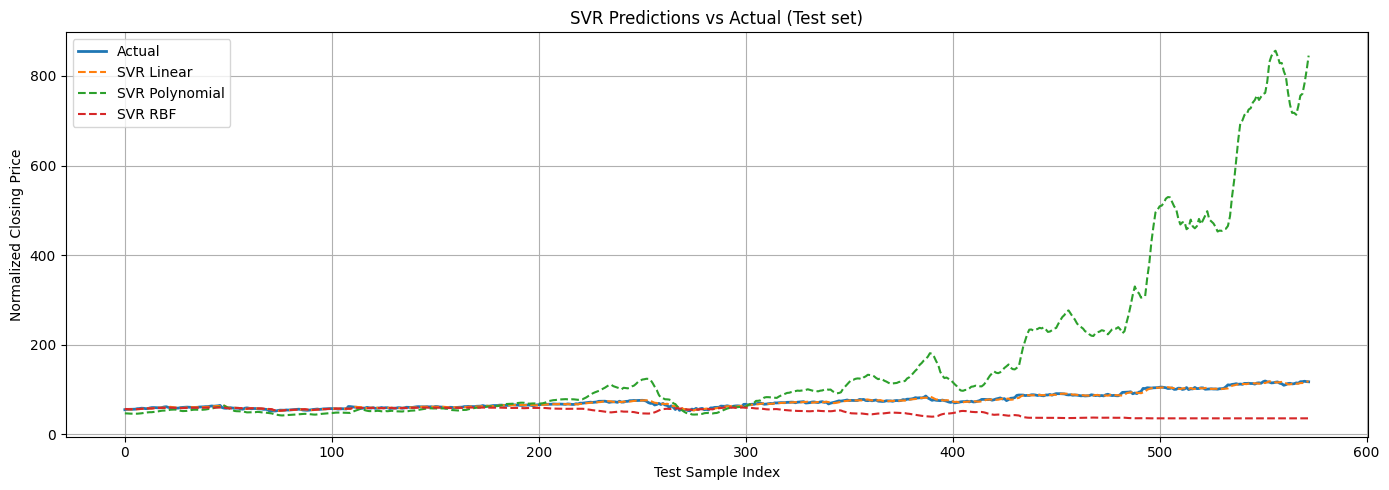

In [58]:
plt.figure(figsize=(14, 5))
test_range = range(len(y_test))
plt.plot(test_range, y_test, label='Actual', linewidth=2)
plt.plot(test_range, pred_linear, label='SVR Linear', linestyle='--')
plt.plot(test_range, pred_poly, label='SVR Polynomial', linestyle='--')
plt.plot(test_range, pred_rbf, label='SVR RBF', linestyle='--')
plt.title("SVR Predictions vs Actual (Test set)")
plt.xlabel("Test Sample Index")
plt.ylabel("Normalized Closing Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

###  Final Conclusion

After exploring multiple SVR models with different kernels, the Linear SVR proved to be the most reliable for predicting short-term stock prices. Despite trying more complex kernels like Polynomial and RBF including tuning their hyperparameters and testing different scalers they either overfitted or failed to generalize well. The Linear model, on the other hand, delivered the lowest errors and followed the actual price trend closely. This suggests that for this particular dataset and task, a simple linear relationship based on recent closing prices is enough to produce strong results. The overall process from feature selection to evaluation confirmed that a clean, well-prepared univariate model can perform surprisingly well in time series forecasting.
